In [1]:
# conda install -c conda-forge geopandas 

# pip install dash-bootstrap-components

# #Please run this to install Geopandas and dash bootstrap components

<h3>Importing libraries (special imports that are needed stated above this cell)<h3>

In [2]:
import pandas as pd
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import geopandas as gpd
from statsmodels.formula.api import ols,glm
import statsmodels.api as sm
import matplotlib as mpl
import seaborn as sns


<h2>Reading from 9 CSV files</h2>


In [3]:
mrtsg = pd.read_csv("mrtsg.csv")
railLine = gpd.read_file("railline/G_MP14_RAIL_LI.shp")
df_01 = pd.read_csv("transport_node_train_202001.csv", sep=',')
df_02 = pd.read_csv("transport_node_train_202002.csv", sep=',')
df_03 = pd.read_csv("transport_node_train_202003.csv", sep=',')
df_04 = pd.read_csv("transport_node_train_202004.csv", sep=',')
df_05 = pd.read_csv("transport_node_train_202005.csv", sep=',')
df_06 = pd.read_csv("transport_node_train_202006.csv", sep=',')
df_07 = pd.read_csv("transport_node_train_202007.csv", sep=',')

In [4]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
# increase cell size

In [5]:
mrtsg.head(5)

,OBJECTID,STN_NAME,STN_NO,X,Y,Latitude,Longitude,COLOR
0,12,ADMIRALTY MRT STATION,NS10,24402.1063,46918.1131,1.440585,103.800998,RED
1,16,ALJUNIED MRT STATION,EW9,33518.6049,33190.0020,1.316433,103.882893,GREEN
2,33,ANG MO KIO MRT STATION,NS16,29807.2655,39105.7720,1.369933,103.849553,RED
3,81,BAKAU LRT STATION,SE3,36026.0821,41113.8766,1.388093,103.905418,OTHERS
4,80,BANGKIT LRT STATION,BP9,21248.2460,40220.9693,1.380018,103.772667,OTHERS


In [6]:
mrtsg.isnull().sum().sort_values(ascending=False)
# NO NULL VALUES

OBJECTID     0
STN_NAME     0
STN_NO       0
X            0
Y            0
Latitude     0
Longitude    0
COLOR        0
dtype: int64

In [7]:
mrtsg.STN_NAME.value_counts()

DHOBY GHAUT MRT STATION        3
BISHAN MRT STATION             2
TAMPINES MRT STATION           2
PROMENADE MRT STATION          2
JURONG EAST MRT STATION        2
                              ..
HILLVIEW MRT STATION           1
HOLLAND VILLAGE MRT STATION    1
HOUGANG MRT STATION            1
JALAN BESAR MRT STATION        1
YISHUN MRT STATION             1
Name: STN_NAME, Length: 166, dtype: int64

In [8]:
mrtsg[mrtsg.STN_NAME == "DHOBY GHAUT MRT STATION"]

,OBJECTID,STN_NAME,STN_NO,X,Y,Latitude,Longitude,COLOR
52,165,DHOBY GHAUT MRT STATION,CC1,29437.9401,31244.9618,1.298843,103.846236,YELLOW
53,164,DHOBY GHAUT MRT STATION,NE6,29354.3681,31340.3479,1.299705,103.845485,PURPLE
54,144,DHOBY GHAUT MRT STATION,NS24,29424.1448,31229.3143,1.298701,103.846112,RED


In [9]:
mrtsg.drop(['OBJECTID', 'X', 'Y'], axis = 1, inplace=True)
# Dropping columns that are not very relevant for the analysis/map

In [10]:
mrtsg.reset_index()

,index,STN_NAME,STN_NO,Latitude,Longitude,COLOR
0,0,ADMIRALTY MRT STATION,NS10,1.440585,103.800998,RED
1,1,ALJUNIED MRT STATION,EW9,1.316433,103.882893,GREEN
2,2,ANG MO KIO MRT STATION,NS16,1.369933,103.849553,RED
3,3,BAKAU LRT STATION,SE3,1.388093,103.905418,OTHERS
4,4,BANGKIT LRT STATION,BP9,1.380018,103.772667,OTHERS
...,...,...,...,...,...,...
184,184,WOODLANDS SOUTH MRT STATION,TE3,1.427260,103.793863,OTHERS
185,185,WOODLEIGH MRT STATION,NE11,1.339190,103.870808,PURPLE
186,186,YEW TEE MRT STATION,NS5,1.397535,103.747431,RED
187,187,YIO CHU KANG MRT STATION,NS15,1.381756,103.844944,RED


Renaming columns to merge later on.

In [11]:
mrtsg = mrtsg.rename(columns={"STN_NAME": "STATION_NAME", "STN_NO": "STATION_CODE", "COLOR": "COLOR"})
# Renaming column names for merging purposes

In [12]:
mrtsg.info(show_counts=False)
# 189 Rows

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 189 entries, 0 to 188
Data columns (total 5 columns):
 #   Column        Dtype  
---  ------        -----  
 0   STATION_NAME  object 
 1   STATION_CODE  object 
 2   Latitude      float64
 3   Longitude     float64
 4   COLOR         object 
dtypes: float64(2), object(3)
memory usage: 7.5+ KB


In [13]:
counts = mrtsg.groupby(['STATION_NAME'])['STATION_NAME'].apply(lambda x: x[x.str.contains('LRT')].count())
mrtOrLRT = counts.value_counts()
mrtOrLRT.index= ['Number of unique MRT stations','Number of unique LRT stations']
mrtOrLRT


Number of unique MRT stations    123
Number of unique LRT stations     43
Name: STATION_NAME, dtype: int64

The degree of granularity for this dataset is by each MRT station, along with information such as color, coordinates and its code.

<h5>Next segment: (MRT ridership from 2020-01 to 2020-07) - 7 datasets</h5>

In [14]:
dataframes = [df_01,df_02,df_03,df_04,df_05,df_06,df_07]
df_names = ["df_01", "df_02", "df_03", "df_04", "df_05", "df_06", "df_07"]
for i, n in zip(dataframes, df_names):
    nullOrno = i.isnull().values.any()
    if nullOrno:
        print(n, "has null values")
    else:
        print(n, "does not have null values")

df_01 has null values
df_02 does not have null values
df_03 does not have null values
df_04 does not have null values
df_05 does not have null values
df_06 does not have null values
df_07 does not have null values


Make sure its filled up

In [15]:
df_01.fillna(value= np.nan ,method = None , inplace=True)
# Make sure its filled up
df_01.isnull().sum()
# Null value detector We can see that TOTAL_TAP_IN_VOLUME (variable is numerical)

YEAR_MONTH              0
DAY_TYPE                0
TIME_PER_HOUR           0
PT_TYPE                 0
PT_CODE                 0
TOTAL_TAP_IN_VOLUME     2
TOTAL_TAP_OUT_VOLUME    0
dtype: int64

In [16]:
# Closer look at empty values
# Indexs of the 2 empty values
idxNull = df_01[df_01['TOTAL_TAP_IN_VOLUME'].isnull()].index
df_01[df_01['TOTAL_TAP_IN_VOLUME'].isnull()]

,YEAR_MONTH,DAY_TYPE,TIME_PER_HOUR,PT_TYPE,PT_CODE,TOTAL_TAP_IN_VOLUME,TOTAL_TAP_OUT_VOLUME
1497,2020-01,WEEKENDS/HOLIDAY,10,TRAIN,EW3,NaN,4758
6890,2020-01,WEEKDAY,6,TRAIN,DT20,NaN,3227


In [17]:
df_01.describe().T

,count,mean,std,min,25%,50%,75%,max
TIME_PER_HOUR,6937.0,13.344097,6.111654,0.0,9.0,14.0,19.0,23.0
TOTAL_TAP_IN_VOLUME,6935.0,10760.223648,17578.002476,0.0,1333.5,4270.0,13250.5,301968.0
TOTAL_TAP_OUT_VOLUME,6937.0,11045.959781,18058.083636,0.0,1482.0,4505.0,13256.0,336250.0


Due to how skewed the data is, we will be replacing with the median

In [18]:
df_01["TOTAL_TAP_IN_VOLUME"] =df_01.groupby(['PT_CODE', 'YEAR_MONTH'])[['TOTAL_TAP_IN_VOLUME']].transform(lambda x: x.fillna(x.median()))
# Fill NaN values

In [19]:
df_01.iloc[idxNull]
# We can see that they are filled with values 

,YEAR_MONTH,DAY_TYPE,TIME_PER_HOUR,PT_TYPE,PT_CODE,TOTAL_TAP_IN_VOLUME,TOTAL_TAP_OUT_VOLUME
1497,2020-01,WEEKENDS/HOLIDAY,10,TRAIN,EW3,8489.0,4758
6890,2020-01,WEEKDAY,6,TRAIN,DT20,3089.0,3227


In [20]:
df_01['TOTAL_TAP_IN_VOLUME']=df_01['TOTAL_TAP_IN_VOLUME'].astype('int64')
# changing data type

In [21]:
# if np.unique([set(dataframes[0].dtypes) == set(df.dtypes) for df in dataframes]):
#     print('All df column have same data types/same structure')
# else:
#     print('Different datatypes and same structure')

In [22]:
for y,n in zip(dataframes,df_names):
    print(n,'has',len(y.PT_CODE.unique()), 'unique mrt stations')
# We can see that there are some inconsistencies.


df_01 has 174 unique mrt stations
df_02 has 174 unique mrt stations
df_03 has 174 unique mrt stations
df_04 has 174 unique mrt stations
df_05 has 159 unique mrt stations
df_06 has 160 unique mrt stations
df_07 has 159 unique mrt stations


In [23]:
print('This is the difference between month of june and may:',set(df_06.PT_CODE) - set(df_05.PT_CODE))

df_06[df_06.PT_CODE == "BP14"]
# This is quite strange as BP14 has been closed for some time may be due to inspection check/maintenance hence the tap in.
# We will then drop this

This is the difference between month of june and may: {'BP14'}


,YEAR_MONTH,DAY_TYPE,TIME_PER_HOUR,PT_TYPE,PT_CODE,TOTAL_TAP_IN_VOLUME,TOTAL_TAP_OUT_VOLUME
5394,2020-06,WEEKDAY,15,TRAIN,BP14,1,0


We will drop BP14 as it is inconsistent/could be inspection check/maintenance/ data error. (outlier)

In [24]:
df_06 = df_06.drop(df_06[df_06.PT_CODE == "BP14"].index) 

Differences exists as some of them interchanges while others are normal mrt stations that are part of interchanges. for example: NS4 and NS4/BP1 are the same but they exist as normal mrt station and interchange respectively. We will clean this up later after concatenating/merge

In [25]:
print('Set Difference between the unique/ Will clean this later on ', set(df_07.PT_CODE) - set(df_03.PT_CODE))


Set Difference between the unique/ Will clean this later on  {'CE1/DT16', 'EW24/NS1', 'CC4/DT15', 'CC19/DT9', 'CG1/DT35', 'DT1/PB6', 'EW14/NS26', 'NE17/PTC', 'NS21/DT11', 'NE1/CC29', 'NE4/DT19', 'NS9/TE2', 'NE7/DT12', 'NS4/BP1', 'NS24/NE6/CC1', 'EW8/CC9', 'NE12/CC13', 'NS17/CC15', 'NE16/STC', 'EW2/DT32', 'EW12/DT14', 'NS27/CE2', 'EW13/NS25', 'CC10/DT26', 'NS12', 'TE1', 'EW16/NE3', 'CC22/EW21', 'TE3'}


In [26]:
if np.unique([set(dataframes[0].dtypes) == set(df.dtypes) for df in dataframes]):
    print('All df column have same data types/same structure')
else:
    print('Different datatypes and same structure')

All df column have same data types/same structure


<h4>Concatenating all the datasets</h4> We will concatenate them as each dataset represent one month of ridership and they have the same structure

In [27]:
finaldf = pd.concat([df_01,df_02,df_03,df_04,df_05,df_06,df_07], axis = 0 , ignore_index=True)

In [28]:
print(f'This dataset has {len(finaldf)} rows, and {len(finaldf.columns)} columns. Each row of the dataset represents total Number of tap ins/out for that specific time (TIME_PER_HOUR), for that day, and for that entire month ')

This dataset has 46671 rows, and 7 columns. Each row of the dataset represents total Number of tap ins/out for that specific time (TIME_PER_HOUR), for that day, and for that entire month 


This time span of this dataset is for 7 months, from 2020-01 to 2020-07

In [29]:
finaldf.head()

,YEAR_MONTH,DAY_TYPE,TIME_PER_HOUR,PT_TYPE,PT_CODE,TOTAL_TAP_IN_VOLUME,TOTAL_TAP_OUT_VOLUME
0,2020-01,WEEKDAY,11,TRAIN,NS7,15357,12690
1,2020-01,WEEKENDS/HOLIDAY,11,TRAIN,NS7,9137,14258
2,2020-01,WEEKDAY,16,TRAIN,SW4,908,1721
3,2020-01,WEEKENDS/HOLIDAY,16,TRAIN,SW4,604,693
4,2020-01,WEEKENDS/HOLIDAY,10,TRAIN,CC5,1330,1577


As some interchanges are separated by - and / we will change for all to be separated by a dash.

In [30]:
finaldf['PT_CODE'] = finaldf['PT_CODE'].str.replace("-" , '/')
# Replacing '-' with '/' as they roughly mean the same thing

As cells under the station code column are in the form of interchanges and normal MRT stations. There are some normal mrt stations that should be an interchange.
For e.g EW8 exists alone for some cells, and EW8/CC9 exists for some cells. We will change all EW8 to Ew8/CC9 and vice versa. This is done by checking if individual MRT stations is inside interchange (EW8 in EW8/CC9), and replacing it by interchange.

In [31]:
# Extracting the interchanges /non interchages

# Unique interchanges
uniqueMrtInterchanges = finaldf.loc[finaldf['PT_CODE'].str.contains('/'), 'PT_CODE'].unique()
nonInterchanges = finaldf.loc[~finaldf['PT_CODE'].str.contains('/'), 'PT_CODE']
nonInterchangesIDX = finaldf.loc[~finaldf['PT_CODE'].str.contains('/'), 'PT_CODE'].index

for k in nonInterchanges:
    for y in uniqueMrtInterchanges:
        if k in y.split('/'):
            nonInterchanges.replace(k,y, inplace=True)

# Replacing 
finaldf.loc[nonInterchangesIDX, 'PT_CODE'] = pd.Series(nonInterchanges)

#unique Inter changes
mrtinterchanges =finaldf.loc[finaldf['PT_CODE'].str.contains("/") , 'PT_CODE'].unique()

def grpSum(df):
    df.TOTAL_TAP_IN_VOLUME = df.TOTAL_TAP_IN_VOLUME.sum()
    df.TOTAL_TAP_OUT_VOLUME = df.TOTAL_TAP_OUT_VOLUME.sum()
    return df.head(1)
finaldf = finaldf.groupby(['PT_CODE','YEAR_MONTH','DAY_TYPE', 'TIME_PER_HOUR']).apply(grpSum).reset_index(drop =True)

# Changing mrt sg
def changeStnName(code):
    for y in range(len(mrtinterchanges)):
        if "/" in mrtinterchanges[y]:
            individualmrt = mrtinterchanges[y].split('/')
            if code in individualmrt:
                return mrtinterchanges[y]
            elif y == len(mrtinterchanges) -1:
                return code
            else:
                continue
        else:
            return code


mrtsg['STATION_CODE'] = mrtsg['STATION_CODE'].apply(changeStnName)

I also changed the dataset 'mrtsg' the same way i did with 'finaldf' ^

However there are some repeats from the mrtsg dataset. We will finally then groupby the code so as to eliminate the duplicates in the next cell

In [32]:
mrtsg.STATION_CODE.value_counts()
# Duplicates 

CC1/NE6/NS24    3
CC19/DT9        2
NE4/DT19        2
EW2/DT32        2
CC4/DT15        2
               ..
DT3             1
CC21            1
NE14            1
DT22            1
NS13            1
Name: STATION_CODE, Length: 163, dtype: int64

DT/PB6 is a spelling error in finaldf and mrtsg, we will change the name. 

I will replace the erroneous MRT stations with its corresponding CORRECT interchanges for both in finaldf and mrtsg.

Groupby the station code so as to remove duplicates

In [33]:
# mrtsg.STATION_CODE= mrtsg.STATION_CODE.replace("BP6", "DT1/BP6")
# Changing PB6 to BP6 due to typo error.
finaldf['PT_CODE'] = finaldf['PT_CODE'].str.replace("NS24/NE6/CC1", 'CC1/NE6/NS24')
mrtsg.STATION_CODE = mrtsg.STATION_CODE.replace("DT1/PB6", "DT1/BP6")
finaldf['PT_CODE'] = finaldf['PT_CODE'].replace("BP6" , 'DT1/BP6')
mrtsg['STATION_CODE'] = mrtsg['STATION_CODE'].replace('BP6', 'DT1/BP6')
finaldf['PT_CODE'] = finaldf['PT_CODE'].replace("DT1/PB6" , 'DT1/BP6')


def groupByCode(data):
    return data.head(1)     
mrtsg = mrtsg.groupby('STATION_CODE').apply(groupByCode).reset_index(drop = True)
# mrtsg = mrtsg.groupby('STATION_NAME').apply(groupByCode).reset_index(drop = True)
mrtsg.STATION_NAME.value_counts()

FAJAR LRT STATION              1
NOVENA MRT STATION             1
SENGKANG LRT STATION           1
PUNGGOL LRT STATION            1
CHINATOWN MRT STATION          1
                              ..
HILLVIEW MRT STATION           1
BEDOK RESERVOIR MRT STATION    1
TAMPINES WEST MRT STATION      1
TAMPINES EAST MRT STATION      1
WOODLANDS SOUTH MRT STATION    1
Name: STATION_NAME, Length: 162, dtype: int64

Notice PW2 and CC18 are anomalies. Upon further research, PW2 is teck lee lrt station, which is currently unopened light rail station along the Punggol LRT. Hence, it is logical for it not to be included in the tap in dataset. CC18 however, is a future MRT station, similar to teck lee lrt station

In [34]:
print(set(mrtsg['STATION_CODE'])-set(finaldf.PT_CODE))
# Some differences between the 2 datasets
print(set(finaldf.PT_CODE) - set(mrtsg['STATION_CODE']))

{'PW2', 'BP14', 'CC18'}
set()


Removing BP14 as it is closed

In [35]:
mrtsg = mrtsg.drop(mrtsg[mrtsg.STATION_CODE == "BP14"].index) 

# Dropping a closed mrt station




Removal of PW2 and CC18 due as they are not official MRTs (open in future...)

In [36]:
idx1 = mrtsg[mrtsg.STATION_CODE == "PW2"].index
idx2 =mrtsg[mrtsg.STATION_CODE == "CC18"].index


mrtsg.drop(axis = 0, index = [idx1[0],idx2[0]], inplace=True)

finaldf = finaldf.rename(columns={"PT_CODE": "STATION_CODE"})

In [37]:
print(set(mrtsg['STATION_CODE'])-set(finaldf.STATION_CODE))
# After removing the discrepencies...
print(set(finaldf.STATION_CODE) - set(mrtsg['STATION_CODE']))

set()
set()


Merging the datasets based on station code column

In [38]:
finaldf= pd.merge(how='inner',left = finaldf , right = mrtsg , left_on= 'STATION_CODE',  right_on='STATION_CODE')

In [39]:
print('This dataset has ', len(finaldf.columns), 'columns and ', len(finaldf), 'rows')

This dataset has  11 columns and  43960 rows


In [40]:
railLine.head()
# Last dataset that is from datagov, we will use this to plot a map

,OBJECTID,OID_1,GRND_LEVEL,TYPE,INC_CRC,FMEL_UPD_D,X_ADDR,Y_ADDR,SHAPE_Leng,geometry
0,1,0,UNDERGROUND,MRT,43215EF9C877C56F,2014-06-23,29859.1013,30997.7625,826.574555,"LINESTRING (29513.376 31211.449, 29513.618 312..."
1,2,0,UNDERGROUND,MRT,6105B200FED9F6AB,2014-06-23,29847.8403,30983.1468,815.626905,"LINESTRING (29508.584 31196.830, 29508.817 311..."
2,3,0,UNDERGROUND,MRT,11D377899E972359,2014-06-23,29043.1323,31328.9357,610.083840,"LINESTRING (28744.000 31388.314, 28820.801 313..."
3,4,0,UNDERGROUND,MRT,8743FDEC51A13827,2014-06-23,29039.5927,31316.4599,608.693508,"LINESTRING (28740.927 31374.606, 28809.279 313..."
4,5,0,UNDERGROUND,MRT,8D1604C6958EBC87,2014-06-23,28136.7387,31429.3362,854.419016,"LINESTRING (27871.646 31719.024, 27871.921 317..."


<h3>Data exploration</h3>

In [41]:
finaldf.info(show_counts=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43960 entries, 0 to 43959
Data columns (total 11 columns):
 #   Column                Dtype  
---  ------                -----  
 0   YEAR_MONTH            object 
 1   DAY_TYPE              object 
 2   TIME_PER_HOUR         int64  
 3   PT_TYPE               object 
 4   STATION_CODE          object 
 5   TOTAL_TAP_IN_VOLUME   int64  
 6   TOTAL_TAP_OUT_VOLUME  int64  
 7   STATION_NAME          object 
 8   Latitude              float64
 9   Longitude             float64
 10  COLOR                 object 
dtypes: float64(2), int64(3), object(6)
memory usage: 4.0+ MB


In [42]:
finaldf.agg(["nunique", "count"]).T.reset_index()[1:]
# Number of unique values for each column

,index,nunique,count
1,DAY_TYPE,2,43960
2,TIME_PER_HOUR,20,43960
3,PT_TYPE,1,43960
4,STATION_CODE,159,43960
5,TOTAL_TAP_IN_VOLUME,15380,43960
6,TOTAL_TAP_OUT_VOLUME,13953,43960
7,STATION_NAME,159,43960
8,Latitude,159,43960
9,Longitude,159,43960
10,COLOR,6,43960


We can drop this column as they are all the same and pretty self explanatory

In [43]:
finaldf.drop('PT_TYPE', axis=1, inplace=True)

In [44]:
finaldf['TOTAL_TAP_IN_VOLUME'].corr(finaldf['TOTAL_TAP_OUT_VOLUME'])
# High correlation

0.6385057004856182

The total number of tap-ins should match the total number of tap-outs, but however they do not. In some cases the number of tap-outs exceed the number of tap-ins.
(this is strange since people are more likely to forget to tap-out than tap-in). 

Since the data measures only tap-ins and tap-outs, it does not distinguish between tapping out to go back home, or tapping out to transfer to a different MRT line. As such, the total number of tap-ins is likely to over state the number of commutes that are being taken, and the total number of tap-outs will also overstate commuters headed around the station


In [45]:
finaldf.TOTAL_TAP_IN_VOLUME.sum() - finaldf.TOTAL_TAP_OUT_VOLUME.sum()
# One would expect the values for tap in and tap out to match, however they do not.


40119012

We can see that there are some zeroes for tap in and tap out. Moreover, the 50th percentile for tap in/out is very far from the maximum value(301968, 336250) as compared to the minimum (0). This suggests that the values are very right skewed.

In [46]:
finaldf.describe().T

,count,mean,std,min,25%,50%,75%,max
TIME_PER_HOUR,43960.0,13.365833,6.089976,0.000000,9.000000,14.000000,19.000000,23.000000
TOTAL_TAP_IN_VOLUME,43960.0,6928.779527,13374.216384,0.000000,658.750000,2229.000000,7107.250000,301968.000000
TOTAL_TAP_OUT_VOLUME,43960.0,6016.154140,13271.596399,0.000000,252.750000,1479.000000,5685.250000,336250.000000
Latitude,43960.0,1.345316,0.044618,1.265473,1.308383,1.337675,1.384234,1.449051
Longitude,43960.0,103.840725,0.068006,103.636932,103.790665,103.850663,103.892163,103.988321


In [47]:
finaldf[finaldf.TOTAL_TAP_IN_VOLUME ==0].TIME_PER_HOUR.unique()
#Diving deeper, There are 0 tap ins at these timings, these are valid as they are either very late or early.

array([ 0, 23,  5, 20, 22], dtype=int64)

In [48]:
finaldf[finaldf.TOTAL_TAP_OUT_VOLUME == 0].YEAR_MONTH.value_counts().to_frame()

,YEAR_MONTH
2020-07,6314
2020-05,30
2020-04,26
2020-06,26
2020-01,21
2020-02,18
2020-03,17


Entire month of zeroes under the "TOTAL TAP OUT VOLUME" column can be observed. This is extremely unusual and is likely due to data collection/or data error. Since the number of rows is 6314, which accounts for 14% of the dataset length. 

In [49]:
finaldf[(finaldf.TOTAL_TAP_OUT_VOLUME == 0) & (finaldf.YEAR_MONTH == '2020-07')]

,YEAR_MONTH,DAY_TYPE,TIME_PER_HOUR,STATION_CODE,TOTAL_TAP_IN_VOLUME,TOTAL_TAP_OUT_VOLUME,STATION_NAME,Latitude,Longitude,COLOR
230,2020-07,WEEKDAY,5,BP10,3431,0,FAJAR LRT STATION,1.384521,103.770827,OTHERS
231,2020-07,WEEKDAY,6,BP10,8135,0,FAJAR LRT STATION,1.384521,103.770827,OTHERS
232,2020-07,WEEKDAY,7,BP10,8496,0,FAJAR LRT STATION,1.384521,103.770827,OTHERS
233,2020-07,WEEKDAY,8,BP10,4778,0,FAJAR LRT STATION,1.384521,103.770827,OTHERS
234,2020-07,WEEKDAY,9,BP10,3397,0,FAJAR LRT STATION,1.384521,103.770827,OTHERS
...,...,...,...,...,...,...,...,...,...,...
43955,2020-07,WEEKENDS/HOLIDAY,17,TE3,955,0,WOODLANDS SOUTH MRT STATION,1.427260,103.793863,OTHERS
43956,2020-07,WEEKENDS/HOLIDAY,18,TE3,680,0,WOODLANDS SOUTH MRT STATION,1.427260,103.793863,OTHERS
43957,2020-07,WEEKENDS/HOLIDAY,19,TE3,500,0,WOODLANDS SOUTH MRT STATION,1.427260,103.793863,OTHERS
43958,2020-07,WEEKENDS/HOLIDAY,20,TE3,261,0,WOODLANDS SOUTH MRT STATION,1.427260,103.793863,OTHERS


I have tried to perform multiple linear regression for the data, by using other columns to predict the data, however it produced a slightly low R squared value. Hence, it is not a very good fit for the model, and is less useful to make predictions. Using the data from 2020-01 to 2020-06 to predict erroneous values would also not be reliable as we are imputing/estimating 14% of the dataset, which can introduce errors. This also exceeds the 5% limit. As such, i dropped the rows for the month of july

In [50]:
finaldfcopy = finaldf.copy()
finaldfcopy.STATION_NAME = pd.Categorical(finaldfcopy.STATION_NAME)
finaldfcopy['code'] = finaldfcopy.STATION_NAME.cat.codes
finaldfcopy.DAY_TYPE = pd.Categorical(finaldfcopy.DAY_TYPE)
finaldfcopy['day'] = finaldfcopy.DAY_TYPE.cat.codes

withoutZero = finaldfcopy[~(finaldfcopy.YEAR_MONTH == '2020-07') & ~(finaldfcopy.TOTAL_TAP_IN_VOLUME ==0)]
test2 = finaldfcopy[(finaldfcopy.YEAR_MONTH == '2020-07')]
est = ols('TOTAL_TAP_OUT_VOLUME ~ TOTAL_TAP_IN_VOLUME +C(code) + C(day)', data=withoutZero ).fit()
testValue = {"TOTAL_TAP_IN_VOLUME":test2.TOTAL_TAP_IN_VOLUME, 'code':test2.code, 'day': test2.day}
test3 = est.predict(testValue)
est.rsquared
#est.summary() #uncomment to see

0.510273866751612

In [51]:
# Dropping zeros
finaldf.drop(finaldf[(finaldf.TOTAL_TAP_OUT_VOLUME ==0) & (finaldf.YEAR_MONTH == "2020-07") ].index, inplace=True)
finaldf = finaldf.reset_index(drop=True)

In [52]:
finaldf[(finaldf.TOTAL_TAP_OUT_VOLUME == 0) | (finaldf.TOTAL_TAP_IN_VOLUME ==0)]
# Zero values

,YEAR_MONTH,DAY_TYPE,TIME_PER_HOUR,STATION_CODE,TOTAL_TAP_IN_VOLUME,TOTAL_TAP_OUT_VOLUME,STATION_NAME,Latitude,Longitude,COLOR
38,2020-02,WEEKDAY,0,BP10,0,9,FAJAR LRT STATION,1.384521,103.770827,OTHERS
153,2020-05,WEEKDAY,0,BP10,0,1,FAJAR LRT STATION,1.384521,103.770827,OTHERS
268,2020-02,WEEKDAY,0,BP11,0,9,SEGAR LRT STATION,1.387772,103.769617,OTHERS
497,2020-02,WEEKDAY,0,BP12,0,6,JELAPANG LRT STATION,1.386703,103.764523,OTHERS
517,2020-02,WEEKENDS/HOLIDAY,0,BP12,0,2,JELAPANG LRT STATION,1.386703,103.764523,OTHERS
...,...,...,...,...,...,...,...,...,...,...
37542,2020-06,WEEKDAY,5,TE1,0,76,WOODLANDS NORTH MRT STATION,1.448200,103.785100,OTHERS
37577,2020-06,WEEKENDS/HOLIDAY,23,TE1,1,0,WOODLANDS NORTH MRT STATION,1.448200,103.785100,OTHERS
37593,2020-05,WEEKDAY,20,TE3,0,128,WOODLANDS SOUTH MRT STATION,1.427260,103.793863,OTHERS
37609,2020-05,WEEKENDS/HOLIDAY,20,TE3,0,25,WOODLANDS SOUTH MRT STATION,1.427260,103.793863,OTHERS


In [53]:
# function to change to Per day per hour per mrt stn granularity
# original dataset (finaldf) -> one row represents total TAP in/out for entire month for weekends/weekdays for that hour that station
def perDayGranularity(element):
    if element.YEAR_MONTH =='2020-01':
        if element.DAY_TYPE =='WEEKDAY':
            element.TOTAL_TAP_IN_VOLUME /=22
            element.TOTAL_TAP_OUT_VOLUME /=22
        else:
            element.TOTAL_TAP_IN_VOLUME /=9
            element.TOTAL_TAP_OUT_VOLUME /=9
    if element.YEAR_MONTH =='2020-02':
        if element.DAY_TYPE =='WEEKDAY':
            element.TOTAL_TAP_IN_VOLUME /=21
            element.TOTAL_TAP_OUT_VOLUME /=21
        else:
            element.TOTAL_TAP_IN_VOLUME /=8
            element.TOTAL_TAP_OUT_VOLUME /=8
    if element.YEAR_MONTH =='2020-03':
        if element.DAY_TYPE =='WEEKDAY':
            element.TOTAL_TAP_IN_VOLUME /=22
            element.TOTAL_TAP_OUT_VOLUME /=22
        else:
            element.TOTAL_TAP_IN_VOLUME /=9
            element.TOTAL_TAP_OUT_VOLUME /=9
    if element.YEAR_MONTH =='2020-04':
        if element.DAY_TYPE =='WEEKDAY':
            element.TOTAL_TAP_IN_VOLUME /=21
            element.TOTAL_TAP_OUT_VOLUME /=21
        else:
            element.TOTAL_TAP_IN_VOLUME /=9
            element.TOTAL_TAP_OUT_VOLUME /=9
    if element.YEAR_MONTH =='2020-05':
        if element.DAY_TYPE =='WEEKDAY':
            element.TOTAL_TAP_IN_VOLUME /=19
            element.TOTAL_TAP_OUT_VOLUME /=19
        else:
            element.TOTAL_TAP_IN_VOLUME /=12
            element.TOTAL_TAP_OUT_VOLUME /=12
    if element.YEAR_MONTH =='2020-06':
        if element.DAY_TYPE =='WEEKDAY':
            element.TOTAL_TAP_IN_VOLUME /=22
            element.TOTAL_TAP_OUT_VOLUME /=22
        else:
            element.TOTAL_TAP_IN_VOLUME /=8
            element.TOTAL_TAP_OUT_VOLUME /=8
    if element.YEAR_MONTH =='2020-07':
        if element.DAY_TYPE =='WEEKDAY':
            element.TOTAL_TAP_IN_VOLUME /=21
            element.TOTAL_TAP_OUT_VOLUME /=21
        else:
            element.TOTAL_TAP_IN_VOLUME /=10
            element.TOTAL_TAP_OUT_VOLUME /=10
    return element
    
    
finaldf2 =finaldf.apply(perDayGranularity , axis = 1)
finaldf2.TOTAL_TAP_IN_VOLUME= finaldf2.TOTAL_TAP_IN_VOLUME.apply(lambda x: int(x))
finaldf2.TOTAL_TAP_OUT_VOLUME= finaldf2.TOTAL_TAP_OUT_VOLUME.apply(lambda x: int(x))

Exploring factors that determine passenger volume

In [54]:
bins = [4,8, 11,15 ,18,20, 24]
finaldfconv = finaldf.copy()
finaldfconv.TIME_PER_HOUR.replace(0,24,inplace=True)

labels=['Morning (5am to 9am)','Late morning (9am to 12pm)','Noon (12pm to 4pm)','Late afternoon (4pm to 7pm)','Evening - Night (7pm to 9pm)', 'Late night (10pm to 12am)']
subsetted = finaldfconv.groupby([pd.cut(finaldfconv['TIME_PER_HOUR'], bins=bins, labels=labels), 'DAY_TYPE'])[['TOTAL_TAP_IN_VOLUME', 'TOTAL_TAP_OUT_VOLUME']].sum().apply(np.int64)
subsetted.style.set_caption("Total tap in/out volume by times of day. (for all 6 months)")

<IPython.core.display.Javascript object>


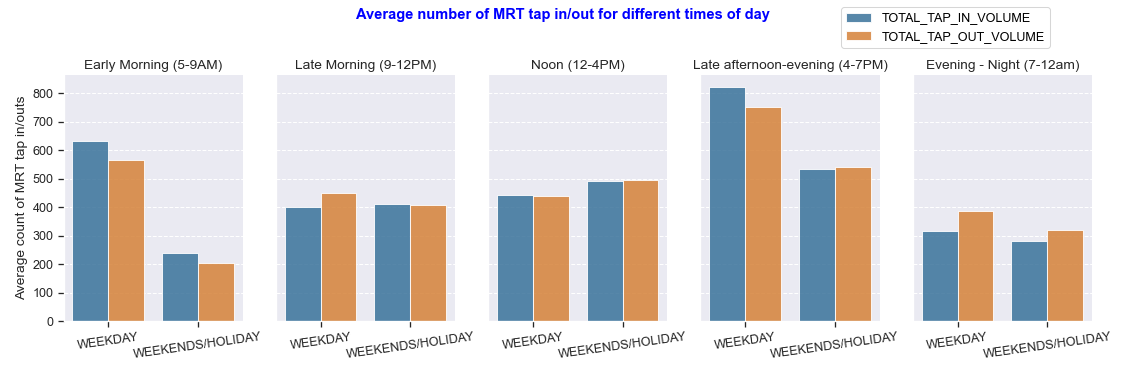

In [55]:
# grouping the data based on times of day

def cleanse(data):
    if data == 0:
        return "Evening - Night (7-12am)" 
    elif data <=8:
        return 'Early Morning (5-9AM)'
    elif data <=11:
        return 'Late Morning (9-12PM)'
    elif data <=15:
        return "Noon (12-4PM)"
    elif data <=18:
        return "Late afternoon-evening (4-7PM)"
    else:
        return "Evening - Night (7-12am)"
finaldf2['Time_day'] = finaldf2.TIME_PER_HOUR.apply(cleanse)



# Set context
sns.set_context('notebook',font_scale = 1.1)
groupbyTime= finaldf2.groupby(['Time_day', "DAY_TYPE"])[['TOTAL_TAP_IN_VOLUME', "TOTAL_TAP_OUT_VOLUME"]].mean().reset_index()

# Melt dataframe 
melteddf2 = pd.melt(finaldf2, value_vars=['TOTAL_TAP_IN_VOLUME', 'TOTAL_TAP_OUT_VOLUME'], id_vars=("DAY_TYPE", "Time_day"), 
                 var_name = ['TAPIN/OUT'],
                 ignore_index = True, value_name = 'Number')


# Plot

with sns.axes_style('darkgrid',{'grid.linestyle': '--'}):
    grid = sns.FacetGrid(data = melteddf2, col="Time_day",height = 5, aspect=0.6, sharey = True,legend_out= False, sharex=False)
    grid.map(sns.barplot, 'DAY_TYPE', "Number",'TAPIN/OUT',
    order = ['WEEKDAY', 'WEEKENDS/HOLIDAY'],
hue_order = ['TOTAL_TAP_IN_VOLUME', 'TOTAL_TAP_OUT_VOLUME'],estimator = np.mean, palette = sns.mpl_palette("tab10", 2), orient = 'v', ci = False, 
          picker = True,saturation=.65,alpha =0.85
         )
    
wkfig = grid.figure
# To rotate labels and for ticks
for axs in grid.axes.flat:
    axs.tick_params('both' , bottom = True)
    axs.set_xticklabels(axs.get_xticklabels(), rotation=8)
    
for axs1 in grid.axes.flat:
    axs1.tick_params('both', left = True)
    break



# Despine
sns.despine(fig=None, ax=None, top=True,right = True, offset=None, trim = False)

# Event handler <please click on bars to see effect>
def handler(event):
    for axes in wkfig.get_axes():
        annotations = [child for child in axes.get_children() if isinstance(child, mpl.text.Annotation)]
        for anno in annotations:
            anno.remove()
    axes = event.mouseevent.inaxes
    rectangle = event.artist
    x = rectangle.get_x()
    y = rectangle.get_y()
    width = rectangle.get_width()
    height = rectangle.get_height()
    annoX = x + (width/2)
    annoY = height 
    annotation = axes.annotate(f'Frequency: {int(annoY)}', (annoX,annoY), 
                              bbox = dict(fc = "black", alpha = 0.7, boxstyle = "Round, pad=0.45"),
                              textcoords='offset points',
                              xytext = (-2,30),
                              arrowprops=dict(arrowstyle='->', color='black'),
                              ha = 'center',
                              va = 'center'
                             )
    annotation.set_color("white")                  
                                
    wkfig.canvas.draw()
    
wkfig.canvas.mpl_connect('pick_event' , handler)



# Setting general info
(grid.set_axis_labels("", "Average count of MRT tap in/outs")
  .set_titles("{col_name}")) 

# Add title
grid.fig.subplots_adjust(top=0.8)
grid.fig.suptitle('Average number of MRT tap in/out for different times of day', fontsize=14, fontweight ='semibold', fontfamily ='Arial', color = 'blue')

# Add legend
plt.legend(bbox_to_anchor=(0.8, 1.30))

plt.show()
# Higher on weekends/PH during 



Outlier detection.

<IPython.core.display.Javascript object>


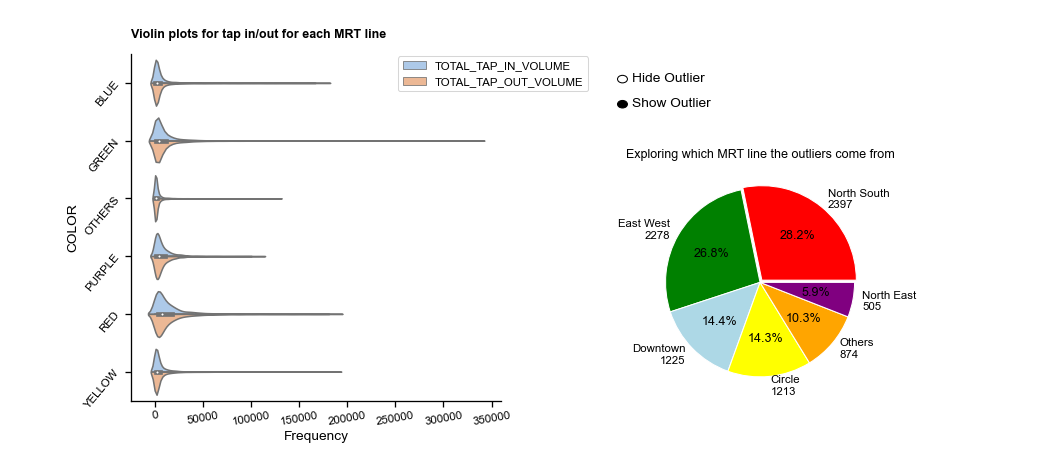

In [56]:
import matplotlib.widgets as wgt
import matplotlib.gridspec as gs

gs1 = gs.GridSpec(nrows = 2, ncols = 2 , width_ratios = [1,1], height_ratios = [1,3])

fig = plt.figure(figsize =(14,6) )
ax2 = fig.add_subplot(4,7,5)
ax = fig.add_subplot(1, 2, 1)
ax3 = fig.add_subplot(gs1[1,1])

meltd = pd.melt(finaldf, value_vars=['TOTAL_TAP_IN_VOLUME', 'TOTAL_TAP_OUT_VOLUME'], id_vars=['STATION_NAME', "TIME_PER_HOUR", "COLOR", "DAY_TYPE"],
                var_name = ['TAPIN/OUT'], ignore_index = True, value_name = 'Frequency')



button = wgt.RadioButtons(ax2, ['Hide Outlier','Show Outlier'], active=1, activecolor='black')

colorpal = list({"RED": "tab:red","GREEN":"tab:green","lightblue":"tab:lightblue", "YELLOW": "tab:yellow","ORANGE":"tab:blue", "PURPLE": "tab:purple"})
sns.set_context('notebook')
sns.axes_style('darkgrid')

q1 = finaldf.TOTAL_TAP_IN_VOLUME.quantile(0.25)
q3 = finaldf.TOTAL_TAP_IN_VOLUME.quantile(0.75)

q1out = finaldf.TOTAL_TAP_OUT_VOLUME.quantile(0.25)
q3out = finaldf.TOTAL_TAP_OUT_VOLUME.quantile(0.75)

iqr = q3-q1
upperfence = (1.5*iqr) + q3
lowerfence = q1 - (1.5*iqr)

iqrout = q3out-q1out
upperfenceout = (1.5*iqrout) + q3out
lowerfenceout = q1out - (1.5*iqrout)


lbl = ['North South','East West', 'Downtown', 'Circle', 'Others', "North East"]
def update_button_info(label):
    ax.clear()
    if label == 'Show Outlier':
        ax3.clear()
        ax.set_title('Violin plots for tap in/out for each MRT line',loc='left', pad=15, fontweight='bold')
        violin_plot = sns.violinplot(x="Frequency",y ='COLOR', data = meltd, ax = ax  , orient = 'h', palette = 'pastel', hue = 'TAPIN/OUT',split=True
                                    ,saturation=.7, order= ['BLUE','GREEN',"OTHERS","PURPLE","RED","YELLOW"])
        ax.legend(bbox_to_anchor=(1.25, 1.01))

        ax.tick_params(axis='x', labelrotation=10)
        ax.tick_params(axis='y', labelrotation=50)
        ax3.set_title('Exploring which MRT line the outliers come from')
        dataTapIn = finaldf[(finaldf.TOTAL_TAP_IN_VOLUME >upperfence) | (finaldf.TOTAL_TAP_IN_VOLUME < lowerfence)][['COLOR', 'TOTAL_TAP_IN_VOLUME']]
        dataTapOut = finaldf[(finaldf.TOTAL_TAP_OUT_VOLUME >upperfenceout) | (finaldf.TOTAL_TAP_OUT_VOLUME < lowerfenceout)][['COLOR', 'TOTAL_TAP_OUT_VOLUME']]
        data = dataTapOut.append(dataTapIn)
        data =data.melt('COLOR').dropna()

        data.COLOR.value_counts().plot(kind = 'pie',autopct="%.1f%%",labels = [f'{i}\n{y}' for i,y in zip(lbl,data.COLOR.value_counts()) ],
                                colors = colorpal,wedgeprops={"edgecolor":"w",'linewidth': 1, 'linestyle': 'solid', 'antialiased': True},explode=(0.03,0,0,0,0,0), ax=ax3 )
        ax3.set_ylabel('')
        ax3.legend().set_visible(False)
        
    else:
        ax.clear()
        dataTapIn = finaldf[(finaldf.TOTAL_TAP_IN_VOLUME <upperfence) & (finaldf.TOTAL_TAP_IN_VOLUME > lowerfence)][['COLOR', 'TOTAL_TAP_IN_VOLUME']]
        dataTapOut = finaldf[(finaldf.TOTAL_TAP_OUT_VOLUME <upperfenceout) & (finaldf.TOTAL_TAP_OUT_VOLUME > lowerfenceout)][['COLOR', 'TOTAL_TAP_OUT_VOLUME']]
        data = dataTapOut.append(dataTapIn)
        datas1 =data.melt('COLOR').dropna()

#         datas1 = pd.melt(datas, value_vars=['TOTAL_TAP_IN_VOLUME', 'TOTAL_TAP_OUT_VOLUME'], id_vars=['STATION_NAME', "TIME_PER_HOUR", "COLOR", "DAY_TYPE"],
#                 var_name = ['TAPIN/OUT'], ignore_index = True, value_name = 'Frequency')
        
        violin_plot = sns.violinplot(x="value",y ='COLOR', data = datas1, ax = ax  , orient = 'h', palette = 'pastel', hue = 'variable',split=True
                                    ,saturation=.7, order= ['BLUE','GREEN',"OTHERS","PURPLE","RED","YELLOW"],cut=0)
        ax.legend(bbox_to_anchor=(1.4, 1.13))
        sns.axes_style('darkgrid')
        ax.set_title('Violin plots of each MRT line (outliers hidden)',loc='left', pad=15, fontweight='bold')
        medians = datas1.groupby(['COLOR'])['value'].median()
        for tick,label in zip([2,5,3,4,1,0],ax.get_yticklabels()):
            ax.annotate(f'Median: {int(medians[tick])}', xy=(medians[tick], tick),
             xycoords='data',
             xytext=(medians[tick] +500, tick-0.3),
             textcoords='data',
             arrowprops=dict(arrowstyle= '->',
                             color='k',
                             lw=1),bbox=dict(facecolor='#445A64'),color = 'white',verticalalignment = "bottom",fontweight='bold'
                       )            
        ax.tick_params(axis='x', labelrotation=20)
        ax.tick_params(axis='y', labelrotation=50)
        ax3.legend().set_visible(False)
        plt.tight_layout()
        
        
    fig.canvas.draw()
ax2.axis('off')

update_button_info('Show Outlier')
button.on_clicked(update_button_info)
# plt.tight_layout()

sns.despine()

plt.show()
# Due to the data having extreme outliers, median will be used as a measure of centers, 
# as mean is heavily influenced by outliers


In [57]:
outlier = finaldf[(finaldf.TOTAL_TAP_IN_VOLUME >upperfence) | (finaldf.TOTAL_TAP_IN_VOLUME < lowerfence)]
# outlier and outlierz represents outliers for tap in and tap out respectively
outlierz = finaldf[(finaldf.TOTAL_TAP_OUT_VOLUME >upperfenceout) | (finaldf.TOTAL_TAP_OUT_VOLUME < lowerfenceout)]
print('Deeping deeper into outliers: Most outliers exist between 4-7 PM and 7-8 AM. This may be due to MRT peak hour (travel to and fro from work/school)')
print(outlier.TIME_PER_HOUR.value_counts().to_frame())
print(outlierz.TIME_PER_HOUR.value_counts().to_frame())
# Shows that most outliers are around 5-8pm and 7-8am. This is not surprising as this these periods are peak hour, and MRT stations tend to be crowded.
# Most outliers come from crowded interchanegs/ and are near facilities such as shopping malls e.g JEM/AMK hub. hence, it would likely be very crowded, hence it makes complete sense to be outliers.

Deeping deeper into outliers: Most outliers exist between 4-7 PM and 7-8 AM. This may be due to MRT peak hour (travel to and fro from work/school)
    TIME_PER_HOUR
18            423
17            399
7             312
19            297
8             290
16            261
12            234
13            232
15            222
20            221
14            220
9             212
6             204
11            191
10            169
21            169
22            104
5              28
23             16
    TIME_PER_HOUR
18            411
8             365
7             355
19            345
17            333
16            251
20            244
9             230
13            227
14            227
15            226
12            210
10            187
21            183
11            165
22            142
6             141
23             46


Investigating where most of the outliers come from

In [58]:
print(outlier.STATION_NAME.value_counts().head(10).to_frame())
# Top outliers for tap in and tap out
outlierz.STATION_NAME.value_counts().head(10).to_frame()

                         STATION_NAME
JURONG EAST MRT STATION           136
YISHUN MRT STATION                120
TAMPINES MRT STATION              115
ANG MO KIO MRT STATION            111
BOON LAY MRT STATION              111
NEWTON MRT STATION                105
ADMIRALTY MRT STATION             103
SERANGOON MRT STATION              99
ORCHARD MRT STATION                98
PAYA LEBAR MRT STATION             96


,STATION_NAME
JURONG EAST MRT STATION,136
ANG MO KIO MRT STATION,124
YISHUN MRT STATION,123
TAMPINES MRT STATION,117
BOON LAY MRT STATION,117
WOODLANDS MRT STATION,116
NEWTON MRT STATION,112
SENGKANG LRT STATION,104
ORCHARD MRT STATION,104
SERANGOON MRT STATION,102


In [59]:
print('Top Information about top outliers of TAP Ins/outs, We can see that most come from East West Line, mostly around 8pm or 6pm. Most are CBD areas')
outlier.sort_values(['TOTAL_TAP_IN_VOLUME'], axis=0, ascending=False).groupby(['COLOR', 'STATION_NAME']).head().reset_index(drop=True).head(10)
outlierz.sort_values(['TOTAL_TAP_OUT_VOLUME'], axis=0, ascending=False).groupby(['COLOR', 'STATION_NAME']).head().reset_index(drop=True).head(10)


Top Information about top outliers of TAP Ins/outs, We can see that most come from East West Line, mostly around 8pm or 6pm. Most are CBD areas


,YEAR_MONTH,DAY_TYPE,TIME_PER_HOUR,STATION_CODE,TOTAL_TAP_IN_VOLUME,TOTAL_TAP_OUT_VOLUME,STATION_NAME,Latitude,Longitude,COLOR
0,2020-01,WEEKDAY,8,EW14/NS26,10098,336250,RAFFLES PLACE MRT STATION,1.284126,103.851457,GREEN
1,2020-02,WEEKDAY,8,EW14/NS26,8874,278747,RAFFLES PLACE MRT STATION,1.284126,103.851457,GREEN
2,2020-01,WEEKDAY,8,EW15,18679,265606,TANJONG PAGAR MRT STATION,1.276521,103.845861,GREEN
3,2020-03,WEEKDAY,8,EW14/NS26,8801,256796,RAFFLES PLACE MRT STATION,1.284126,103.851457,GREEN
4,2020-01,WEEKDAY,9,EW14/NS26,12606,235501,RAFFLES PLACE MRT STATION,1.284126,103.851457,GREEN
5,2020-02,WEEKDAY,8,EW15,15611,229581,TANJONG PAGAR MRT STATION,1.276521,103.845861,GREEN
6,2020-03,WEEKDAY,8,EW15,14992,205779,TANJONG PAGAR MRT STATION,1.276521,103.845861,GREEN
7,2020-01,WEEKDAY,18,EW24/NS1,239266,198338,JURONG EAST MRT STATION,1.333153,103.742311,GREEN
8,2020-01,WEEKDAY,7,EW24/NS1,82131,194076,JURONG EAST MRT STATION,1.333153,103.742311,GREEN
9,2020-02,WEEKDAY,9,EW14/NS26,9491,192115,RAFFLES PLACE MRT STATION,1.284126,103.851457,GREEN


<IPython.core.display.Javascript object>


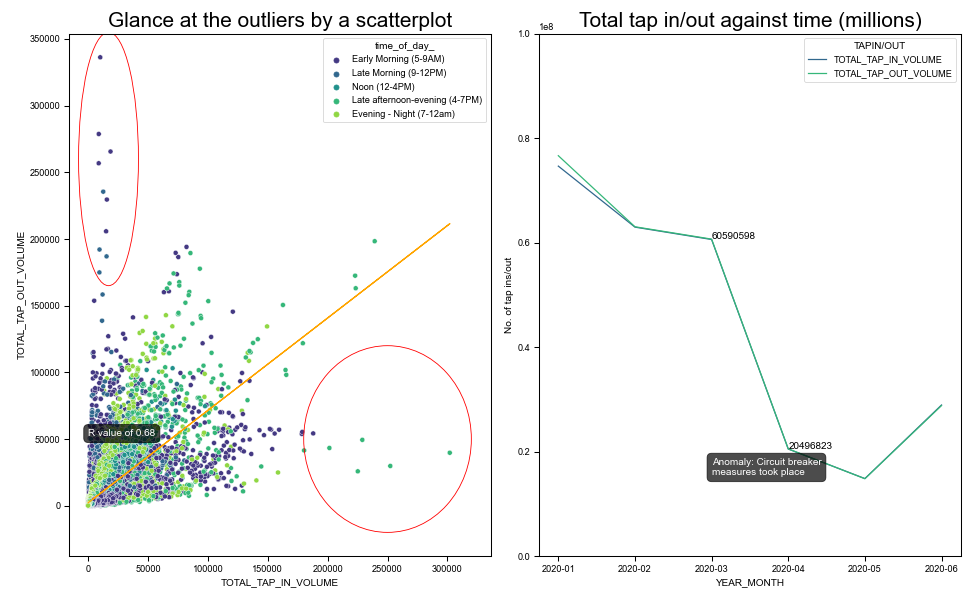

In [60]:
from matplotlib.patches import Ellipse, Circle

def changingtoTimes(data):
    if data == 0:
        return "Evening - Night (7-12am)" 
    elif data <=8:
        return 'Early Morning (5-9AM)'
    elif data <=11:
        return 'Late Morning (9-12PM)'
    elif data <=15:
        return "Noon (12-4PM)"
    elif data <=18:
        return "Late afternoon-evening (4-7PM)"
    else:
        return "Evening - Night (7-12am)"
finaldf['time_of_day_'] = finaldf.TIME_PER_HOUR.apply(changingtoTimes)




sns.set_context('paper')
_twofig = plt.figure( figsize = (13,8))
scatteraxis  = _twofig.add_subplot(121)

scatt = sns.scatterplot(data = finaldf, x ='TOTAL_TAP_IN_VOLUME', y='TOTAL_TAP_OUT_VOLUME',palette='viridis',marker='o',ax =scatteraxis, hue ='time_of_day_')
circle1 = plt.Circle(xy=(250000, 50000), radius=70000, color='red', fill=False)
scatteraxis.add_patch(circle1)
scatteraxis.add_artist(Ellipse((17000, 260000), 50000, 190000,fill=False, color='red'))

# Plot the best fit line.
m,c = np.polyfit(finaldf.TOTAL_TAP_IN_VOLUME,finaldf.TOTAL_TAP_OUT_VOLUME,1)
y_value_best_fit = m* finaldf.TOTAL_TAP_IN_VOLUME+ c 
corr_matrix = np.corrcoef(finaldf.TOTAL_TAP_IN_VOLUME,finaldf.TOTAL_TAP_OUT_VOLUME)
r_value = np.min(corr_matrix.flatten())
scatteraxis.plot(finaldf.TOTAL_TAP_IN_VOLUME,y_value_best_fit , color = "orange")
scatteraxis.annotate(f"R value of {r_value:.2f}" , (80, m*60 + c + 50000 ), c = "white" ,  bbox = dict(fc = "black", alpha = 0.7, boxstyle = "Round, pad=0.45") )
sns.axes_style('darkgrid')

line = _twofig.add_subplot(122)



meltfinal = pd.melt(finaldf, value_vars=['TOTAL_TAP_IN_VOLUME', 'TOTAL_TAP_OUT_VOLUME'], id_vars=("YEAR_MONTH"), 
                 var_name = ['TAPIN/OUT'],
                 ignore_index = True, value_name = 'No. of tap ins/out')

# plot line graph
linegr= sns.lineplot(x ='YEAR_MONTH',hue='TAPIN/OUT', y='No. of tap ins/out',data=meltfinal,ax=line,estimator=np.sum,palette='viridis',ci=None)
# Labelling the line plot
linegr.annotate(f"Anomaly: Circuit breaker\nmeasures took place" , (2,int(finaldf[finaldf.YEAR_MONTH=='2020-04']['TOTAL_TAP_IN_VOLUME'].sum())-5000000 ), c = "white" ,  bbox = dict(fc = "black", alpha = 0.7, boxstyle = "Round, pad=0.45") )
linegr.annotate(int(finaldf[finaldf.YEAR_MONTH=='2020-03']['TOTAL_TAP_IN_VOLUME'].sum()),xy=(2,finaldf[finaldf.YEAR_MONTH=='2020-03']['TOTAL_TAP_IN_VOLUME'].sum()), xycoords='data')
linegr.annotate(int(finaldf[finaldf.YEAR_MONTH=='2020-04']['TOTAL_TAP_IN_VOLUME'].sum()),xy=(3,finaldf[finaldf.YEAR_MONTH=='2020-04']['TOTAL_TAP_IN_VOLUME'].sum()), xycoords='data')
linegr.set_ylim([0,100000000])

scatteraxis.set_title('Glance at the outliers by a scatterplot', fontsize=20)
linegr.set_title('Total tap in/out against time (millions)',fontsize=20)

plt.tight_layout()
_twofig.show()


<IPython.core.display.Javascript object>


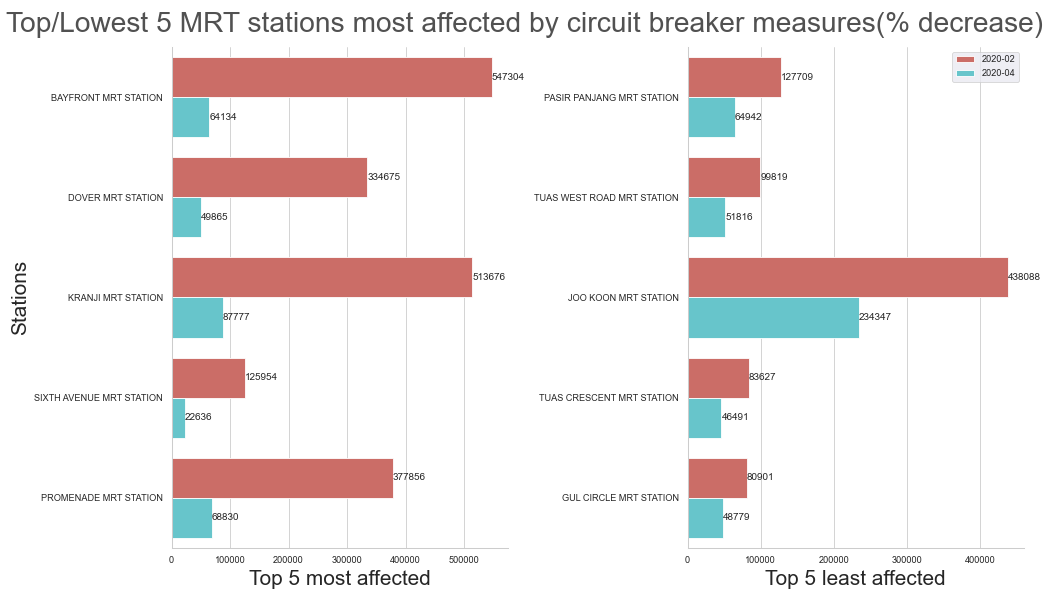

In [61]:
feb = finaldf[(finaldf.YEAR_MONTH == '2020-02') & (finaldf.STATION_NAME.str.contains('MRT', regex = False) )  ].groupby('STATION_NAME')['TOTAL_TAP_OUT_VOLUME'].sum()
april = finaldf[(finaldf.YEAR_MONTH == '2020-04') & (finaldf.STATION_NAME.str.contains('MRT', regex = False))  ].groupby('STATION_NAME')['TOTAL_TAP_OUT_VOLUME'].sum()
pctDec = ((feb - april)/feb)*100 

pctDec.sort_values(ascending = False , inplace = True)
top5 = pctDec.dropna().head(5)
bottom5 = pctDec.dropna().tail(5)

sns.set(context = 'paper')
covidfigure = plt.figure( figsize = (14,8))

with sns.axes_style("whitegrid"):
    covidaxis   = covidfigure.add_subplot(121)
    bp1 = sns.barplot(hue = 'YEAR_MONTH' , x = 'TOTAL_TAP_OUT_VOLUME' , ax = covidaxis  , estimator = np.sum ,  orient =  "h" , y = 'STATION_NAME' ,
            data = finaldf[(finaldf["STATION_NAME"].map(lambda x: True in [x in s for s in top5.index]) ) & (finaldf.YEAR_MONTH.map(lambda x: True in [x in s for s in['2020-02'  , '2020-04' ] ]))] ,
                ci = None , order =top5.index,palette="hls" )
    btm5 = covidfigure.add_subplot(122)
    bp2 = sns.barplot(hue = 'YEAR_MONTH' , x = 'TOTAL_TAP_OUT_VOLUME' , ax = btm5  , estimator = np.sum ,  orient =  "h" , y = 'STATION_NAME' ,
            data = finaldf[(finaldf["STATION_NAME"].map(lambda x: True in [x in s for s in bottom5.index]) ) & (finaldf.YEAR_MONTH.map(lambda x: True in [x in s for s in['2020-02'  , '2020-04' ] ]))] ,
                ci = None , order =bottom5.index,palette="hls" )
sns.despine(fig=None, ax=None, top=True,right = True, offset=None, trim = False)


# Setting titles and legends
covidfigure.suptitle("Top/Lowest 5 MRT stations most affected by circuit breaker measures(% decrease)" ,alpha=0.8 , fontsize = 27, )
covidaxis.set_ylabel("Stations" ,  fontsize = 20 )
covidaxis.set_xlabel("Top 5 most affected", fontsize = 20)
btm5.legend(loc='best')
btm5.set_ylabel("")
btm5.set_xlabel("Top 5 least affected", fontsize = 20)
covidaxis.legend().set_visible(False)

# Labels.
for container in bp1.containers:
    bp1.bar_label(container)
for containers in bp2.containers:
    bp2.bar_label(containers)

plt.tight_layout()
plt.show()


In [119]:
finaldf.drop('time_of_day_', axis=1, inplace=True)
finaldf.to_csv('finaldavi1.csv',index=False)
# Loading into csv file

,YEAR_MONTH,DAY_TYPE,TIME_PER_HOUR,STATION_CODE,TOTAL_TAP_IN_VOLUME,TOTAL_TAP_OUT_VOLUME,STATION_NAME,Latitude,Longitude,COLOR
0,2020-01,WEEKDAY,5,BP10,3821,314,FAJAR LRT STATION,1.384521,103.770827,OTHERS
1,2020-01,WEEKDAY,6,BP10,11867,1891,FAJAR LRT STATION,1.384521,103.770827,OTHERS
2,2020-01,WEEKDAY,7,BP10,13962,3666,FAJAR LRT STATION,1.384521,103.770827,OTHERS
3,2020-01,WEEKDAY,8,BP10,8441,3218,FAJAR LRT STATION,1.384521,103.770827,OTHERS
4,2020-01,WEEKDAY,9,BP10,4940,2960,FAJAR LRT STATION,1.384521,103.770827,OTHERS
...,...,...,...,...,...,...,...,...,...,...
37641,2020-06,WEEKENDS/HOLIDAY,18,TE3,401,452,WOODLANDS SOUTH MRT STATION,1.427260,103.793863,OTHERS
37642,2020-06,WEEKENDS/HOLIDAY,19,TE3,316,460,WOODLANDS SOUTH MRT STATION,1.427260,103.793863,OTHERS
37643,2020-06,WEEKENDS/HOLIDAY,20,TE3,164,529,WOODLANDS SOUTH MRT STATION,1.427260,103.793863,OTHERS
37644,2020-06,WEEKENDS/HOLIDAY,21,TE3,76,450,WOODLANDS SOUTH MRT STATION,1.427260,103.793863,OTHERS


<h2>Analysis</h2>

<IPython.core.display.Javascript object>


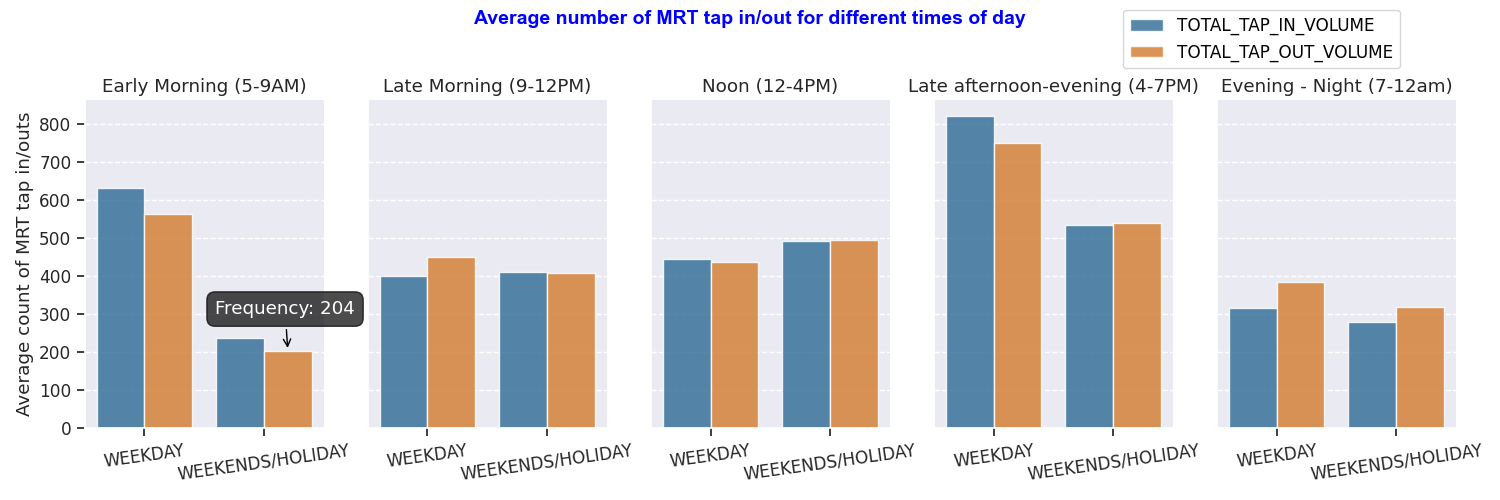

In [57]:
# grouping the data based on times of day
def clean(data):
    if data == 0:
        return "Evening - Night (7-12am)" 
    elif data <=8:
        return 'Early Morning (5-9AM)'
    elif data <=11:
        return 'Late Morning (9-12PM)'
    elif data <=15:
        return "Noon (12-4PM)"
    elif data <=18:
        return "Late afternoon-evening (4-7PM)"
    else:
        return "Evening - Night (7-12am)"
finaldf2['Time_day'] = finaldf2.TIME_PER_HOUR.apply(clean)



# Set context
sns.set_context('notebook',font_scale = 1.1)
# groupbyTime= finaldf2.groupby(['Time_day', "DAY_TYPE"])[['TOTAL_TAP_IN_VOLUME', "TOTAL_TAP_OUT_VOLUME"]].mean().reset_index()

# Melt dataframe 
meltedf = pd.melt(finaldf2, value_vars=['TOTAL_TAP_IN_VOLUME', 'TOTAL_TAP_OUT_VOLUME'], id_vars=("DAY_TYPE", "Time_day"), 
                 var_name = ['TAPIN/OUT'],
                 ignore_index = True, value_name = 'Number')



# Plot

with sns.axes_style('darkgrid',{'grid.linestyle': '--'}):
    g = sns.FacetGrid(data = meltedf, col="Time_day",height = 5, aspect=0.6, sharey = True,legend_out= False, sharex=False)
    g.map(sns.barplot, 'DAY_TYPE', "Number",'TAPIN/OUT',
    order = ['WEEKDAY', 'WEEKENDS/HOLIDAY'],
hue_order = ['TOTAL_TAP_IN_VOLUME', 'TOTAL_TAP_OUT_VOLUME'],estimator = np.mean, palette = sns.mpl_palette("tab10", 2), orient = 'v', ci = False, 
          picker = True,saturation=.65,alpha =0.85
         )
    
myfig = g.figure
# To rotate labels and for ticks
for axs in g.axes.flat:
    axs.tick_params('both' , bottom = True)
    axs.set_xticklabels(axs.get_xticklabels(), rotation=8)
    
for axs1 in g.axes.flat:
    axs1.tick_params('both', left = True)
    break



# Despine
sns.despine(fig=None, ax=None, top=True,right = True, offset=None, trim = False)

# Event handler <please click on bars to see effect>
def handler(event):
    for axes in myfig.get_axes():
        annotations = [child for child in axes.get_children() if isinstance(child, mpl.text.Annotation)]
        for anno in annotations:
            anno.remove()
    axes = event.mouseevent.inaxes
    rectangle = event.artist
    x = rectangle.get_x()
    y = rectangle.get_y()
    width = rectangle.get_width()
    height = rectangle.get_height()
    annoX = x + (width/2)
    annoY = height 
    annotation = axes.annotate(f'Frequency: {int(annoY)}', (annoX,annoY), 
                              bbox = dict(fc = "black", alpha = 0.7, boxstyle = "Round, pad=0.45"),
                              textcoords='offset points',
                              xytext = (-2,30),
                              arrowprops=dict(arrowstyle='->', color='black'),
                              ha = 'center',
                              va = 'center'
                             )
    annotation.set_color("white")                  
                                
    myfig.canvas.draw()
    
myfig.canvas.mpl_connect('pick_event' , handler)



# Setting general info
(g.set_axis_labels("", "Average count of MRT tap in/outs")
  .set_titles("{col_name}")) 

# Add title
g.fig.subplots_adjust(top=0.8)
g.fig.suptitle('Average number of MRT tap in/out for different times of day', fontsize=14, fontweight ='semibold', fontfamily ='Arial', color = 'blue')

# Add legend
plt.legend(bbox_to_anchor=(0.8, 1.30))

plt.show()
# Higher on weekends/PH during 



In [160]:
import dash
import dash_core_components as  dcc
import dash_html_components as html
from dash.dependencies import Input, Output
import plotly.express as px
import dash_bootstrap_components as dbc

csses = [dbc.themes.BOOTSTRAP]
 

# Data preparation.
lines = finaldf2.groupby(['COLOR', 'TIME_PER_HOUR'])[['TOTAL_TAP_IN_VOLUME', "TOTAL_TAP_OUT_VOLUME"]].mean().reset_index()
lines['TOTAL_TAP_IN_VOLUME'] = lines['TOTAL_TAP_IN_VOLUME'].apply(lambda x:int(x))
lines['TOTAL_TAP_OUT_VOLUME'] = lines['TOTAL_TAP_OUT_VOLUME'].apply(lambda x:int(x))
lines.TIME_PER_HOUR.replace(0,24,inplace=True)
lines.sort_values('TIME_PER_HOUR' , inplace = True)

uniqueLines = np.sort(lines.COLOR.unique())
app = dash.Dash(__name__,external_stylesheets=csses, title='Mean Taps against time')

app.layout = html.Div([
    dcc.Dropdown(
        id="ticker",
        options=[{"label": x, "value": x} 
                 for x in uniqueLines],
        value=['BLUE', 'GREEN'],
        clearable=False,
        searchable=False,
        multi= True,
        placeholder= 'Select a MRT Line',className='col-2 offset-md-1'
    ),
    html.Div([
    dcc.RadioItems(id='radiobtn',options=[
       {'label': 'Total tap in', 'value': 'TOTAL_TAP_IN_VOLUME'},
       {'label': 'Total tap out', 'value': 'TOTAL_TAP_OUT_VOLUME'}], value='TOTAL_TAP_IN_VOLUME', className = 'col-md-12')
    ], className='offset-md-1 row')
    ,
    html.Div([
    dcc.Graph(id="time-series-chart", className = 'col-md-6',clickData=None, hoverData=None),
    dcc.Graph(id='bar_pl', figure={}, config={
                      'staticPlot': False,    
                      'scrollZoom': True,      
                      'doubleClick': 'reset',  
                      'showTips': False,      
                      'displayModeBar': True,  
                      'watermark': True,
                        },className='six columns col-md-6')
        ], className='row container')
], className='row')

@app.callback(
    Output("time-series-chart", "figure"), 
    [Input("ticker", "value")],
    [Input('radiobtn', 'value')]
)
def display_time_series(ticker, radiobtn):
    if radiobtn == "TOTAL_TAP_IN_VOLUME":
        radiotext = 'total tap in'
    elif radiobtn == 'TOTAL_TAP_OUT_VOLUME':
        radiotext = 'total tap out'
#     print(radiobtn)

    dataFrame =lines[lines.COLOR.isin(ticker)]
    color_discrete_map = {'BLUE': 'blue', 'GREEN': 'GREEN', 'OTHERS': 'goldenrod', "RED":"RED", "YELLOW":'yellow', "PURPLE":"PURPLE"}
    fig = px.line(data_frame =dataFrame, x='TIME_PER_HOUR', y=radiobtn , color = 'COLOR',range_x=[4,24.0],
                 title=f'Mean frequency of {radiotext} against time', custom_data=lines[["TIME_PER_HOUR", radiobtn, "COLOR"]],
                 color_discrete_map=  color_discrete_map, hover_name ='COLOR')
    fig.update_layout(template = 'ggplot2',
    xaxis=dict(
        autorange=True,
        range=[4,24],
        rangeslider=dict(
            autorange=True,
            range=[4,24]
        )
    ))
#     fig.update_xaxes(range=[4,23])



    newnames = {'BLUE':'DownTown', 'GREEN': 'East West', 'OTHERS': "LRT & TEL", 'PURPLE':"North East", "RED":"North South", "YELLOW":"Circle"}
    fig.for_each_trace(lambda t: t.update(name = newnames[t.name],
                            legendgroup = newnames[t.name],
                    hovertemplate = t.hovertemplate.replace(t.name, newnames[t.name])
                                     ))
    fig.update_traces(
        mode='markers+lines',    
    hovertemplate="""<extra></extra> <em>🕖 %{customdata[0]}</em><br>
<em>🔢 Mean counts: %{customdata[1]}</br></em> <em>MRT Color: %{customdata[2]}</em>"""
)
    
    return fig






@app.callback(
    Output(component_id='bar_pl', component_property='figure'),
    Input(component_id='time-series-chart', component_property='hoverData'),
    Input(component_id='time-series-chart', component_property='clickData'),
    Input(component_id='time-series-chart', component_property='selectedData'),
    Input('radiobtn', 'value')
)
def update_side_graph(hov_data, clk_data, slct_data,radiobtn):
    if radiobtn == "TOTAL_TAP_IN_VOLUME":
        radiotext = 'total tap in'
    elif radiobtn == 'TOTAL_TAP_OUT_VOLUME':
        radiotext = 'total tap out'
    if hov_data is None:
        top5 = finaldf2.groupby(['STATION_NAME']).mean()[radiobtn].nlargest(5).index
        boolmask = finaldf2['STATION_NAME'].isin(top5)
        dff2 = finaldf2[boolmask]
        

        def aggr1(data):
            data.TOTAL_TAP_IN_VOLUME = data.TOTAL_TAP_IN_VOLUME.mean()
            data.TOTAL_TAP_OUT_VOLUME = data.TOTAL_TAP_OUT_VOLUME.mean()
            return data.head(1)
        dff2 = dff2.groupby('STATION_NAME').apply(aggr1).reset_index(drop = True ) 
        dff2.groupby('STATION_NAME').mean().reset_index()
#         dff2 = dff2.sort_values(ascending=False, by=radiobtn)
#         print(dff2)
        fig2 = px.bar(data_frame = dff2, x= radiobtn, y ='STATION_NAME' , color='STATION_NAME',text_auto='.2s',
                     title="Top 5 MRT station by average " + radiotext)
        fig2.update_layout(showlegend=False)
        fig2.update_traces(textfont_size=14, textangle=0, cliponaxis=False)
        
        return fig2
    else:
        hov_time = hov_data['points'][0]['x']
        line = hov_data['points'][0]['hovertext']
        if hov_time == 24:
            hov_time =0
        top5 = finaldf2[(finaldf2.TIME_PER_HOUR == hov_time) & (finaldf2.COLOR == line)].groupby(['STATION_NAME']).mean()[radiobtn].nlargest(5).index
        boolmask = finaldf2['STATION_NAME'].isin(top5)
        #u want to sho wthe this works just the top one doesnt wait 
        dff2 = finaldf2[boolmask]
        top5val = dff2[(dff2.TIME_PER_HOUR==hov_time)].groupby(['STATION_NAME']).mean().reset_index()
#         def aggr(data):
#             data.TOTAL_TAP_IN_VOLUME = data.TOTAL_TAP_IN_VOLUME.mean()
#             data.TOTAL_TAP_OUT_VOLUME = data.TOTAL_TAP_OUT_VOLUME.mean()
#             return data
        dff2 = top5val.sort_values(ascending=False, by=radiobtn)
#         print(dff2)
        
        fig2 = px.bar(data_frame = dff2, x= radiobtn, y ='STATION_NAME', color='STATION_NAME',text_auto='.2s',
                     title=f"Top 5 {line.lower()} line MRT station by\naverage {radiotext}. Time: {hov_time}:00")
        fig2.update_layout(showlegend=False)
        fig2.update_traces(textfont_size=14, textangle=0, cliponaxis=False)
        return fig2
    
    
if __name__ == '__main__':
    app.run_server(port ='8061',debug=True, use_reloader=False)

Dash is running on http://127.0.0.1:8061/

Dash is running on http://127.0.0.1:8061/

Dash is running on http://127.0.0.1:8061/

Dash is running on http://127.0.0.1:8061/

Dash is running on http://127.0.0.1:8061/

Dash is running on http://127.0.0.1:8061/

Dash is running on http://127.0.0.1:8061/

Dash is running on http://127.0.0.1:8061/

Dash is running on http://127.0.0.1:8061/

Dash is running on http://127.0.0.1:8061/

Dash is running on http://127.0.0.1:8061/

Dash is running on http://127.0.0.1:8061/

Dash is running on http://127.0.0.1:8061/

Dash is running on http://127.0.0.1:8061/

Dash is running on http://127.0.0.1:8061/

Dash is running on http://127.0.0.1:8061/

Dash is running on http://127.0.0.1:8061/

Dash is running on http://127.0.0.1:8061/

Dash is running on http://127.0.0.1:8061/

Dash is running on http://127.0.0.1:8061/

Dash is running on http://127.0.0.1:8061/

Dash is running on http://127.0.0.1:8061/

Dash is running on http://127.0.0.1:8061/

Dash is run

,level_0,index,YEAR_MONTH,DAY_TYPE,TIME_PER_HOUR,PT_TYPE,STATION_CODE,TOTAL_TAP_IN_VOLUME,TOTAL_TAP_OUT_VOLUME,STATION_NAME,Latitude,Longitude,COLOR
0,0,0,2020-01,WEEKDAY,5,TRAIN,BP10,105553,117294,FAJAR LRT STATION,1.384521,103.770827,OTHERS
1,1,1,2020-01,WEEKDAY,6,TRAIN,BP10,105553,117294,FAJAR LRT STATION,1.384521,103.770827,OTHERS
2,2,2,2020-01,WEEKDAY,7,TRAIN,BP10,105553,117294,FAJAR LRT STATION,1.384521,103.770827,OTHERS
3,3,3,2020-01,WEEKDAY,8,TRAIN,BP10,105553,117294,FAJAR LRT STATION,1.384521,103.770827,OTHERS
4,4,4,2020-01,WEEKDAY,9,TRAIN,BP10,105553,117294,FAJAR LRT STATION,1.384521,103.770827,OTHERS
...,...,...,...,...,...,...,...,...,...,...,...,...,...
37642,37642,43920,2020-06,WEEKENDS/HOLIDAY,18,TRAIN,TE3,40261,32356,WOODLANDS SOUTH MRT STATION,1.427260,103.793863,OTHERS
37643,37643,43921,2020-06,WEEKENDS/HOLIDAY,19,TRAIN,TE3,40261,32356,WOODLANDS SOUTH MRT STATION,1.427260,103.793863,OTHERS
37644,37644,43922,2020-06,WEEKENDS/HOLIDAY,20,TRAIN,TE3,40261,32356,WOODLANDS SOUTH MRT STATION,1.427260,103.793863,OTHERS
37645,37645,43923,2020-06,WEEKENDS/HOLIDAY,21,TRAIN,TE3,40261,32356,WOODLANDS SOUTH MRT STATION,1.427260,103.793863,OTHERS


In [99]:
import plotly.graph_objects as go
import dash
from dash import dcc 
from dash import html 

import dash_bootstrap_components as dbc

from dash.dependencies import Input, Output

list1 = []
list2 = []
for mrt in railLine.to_crs(epsg=4326).__geo_interface__['features']:
    if mrt['geometry'] is None:
        continue
    for a in mrt['geometry']['coordinates']: 
        if len(a) != 2:
            arr = np.array(a)
            for x in a:
                list1.append(x[0])
                list2.append(x[1])
        else:
            list1.append(a[0])
            list2.append(a[1])
    list1.append(None)
    list2.append(None)
    
def agg(data):
    data.TOTAL_TAP_IN_VOLUME = data.TOTAL_TAP_IN_VOLUME.sum()
    data.TOTAL_TAP_OUT_VOLUME = data.TOTAL_TAP_OUT_VOLUME.sum()
    return data

points = finaldf.groupby(['STATION_NAME' , 'YEAR_MONTH']).apply(agg).reset_index()


css = [dbc.themes.BOOTSTRAP]

 

app1 = dash.Dash(__name__, external_stylesheets=css, title = "Singapore MRT ridership")


indexes = list(range(len(np.sort(points.YEAR_MONTH.unique()))))
dates = np.sort(points.YEAR_MONTH.unique())
app1.layout = html.Div([ 
    html.Div([dbc.Alert("Please wait for MAP with points to finish loading", color="primary", dismissable=True)]),
    html.H2(children = "Singapore MRT ridership from 2020-01 to 2020-06"  , style = {"text-align" : 'center','color':"#9fa6b7", "font-family": "'Arial"}),
    html.Div([  
        html.Div([
             dcc.Dropdown(
        id="dropdown",
        options=[{"label": "Tap In", "value": 'Tap In'} ,{"label": "Tap Out", "value": "Tap Out"} ],
        value= 'Tap In',
        clearable=False,
        multi= False 
    )
        ] , className = 'col-2')
       ,
    dcc.Slider(
        # tooltip={"placement": "top", "always_visible": True},
    id = 'slider',
    min = min(indexes),
    max =  max(indexes),
    step=None,
    marks={y:str(x) for x,y in zip(dates,indexes)
    },
    value=0, className = "col-10" )
    
    
    ] , className = 'row container mx-auto'), 
    
   dcc.Graph(id="Map", style={'background-color' : '#171b26'})
], style = {'background-color' : '#171b26', 'color':"#9fa6b7"})

@app1.callback(
    Output("Map", "figure"), 
    Input("dropdown" , 'value'),
    Input("slider" , 'value')
)
def update_graph(inorout, time):
    eachdata = points[points.YEAR_MONTH == dates[time]]
#     print(eachdata)
    maximum =  points.TOTAL_TAP_IN_VOLUME.max()  if inorout == 'Tap In'  else points.TOTAL_TAP_OUT_VOLUME.max()
    fig = go.Figure(go.Scattermapbox(
    mode = "lines + markers",
    lon =list1,
    lat = list2,
    marker = {'size': 3, 'allowoverlap':True},
    name = 'MRT Lines',
    text = 'Line',
    showlegend = False
    ))


    fig.add_trace(go.Scattermapbox(
        visible = True,   
        mode= "markers",
        lon= eachdata['Longitude'], lat = eachdata['Latitude'],
        marker_size=14, 
        marker ={'allowoverlap':True, 'showscale':True,
                'colorscale':'aggrnyl' , 'color': eachdata.TOTAL_TAP_IN_VOLUME  if inorout == 'Tap In'  else eachdata.TOTAL_TAP_OUT_VOLUME,
                'reversescale' :True,
                'cmin': 0, 'cmax': maximum,
                 'colorbar':{'title':{'font':{'color': "#9fa6b7"}, 'text':'Counts'}, 'titleside':'top', 'thickness':13, 'tickcolor':"#9fa6b7", 'tickfont':{"color":"#9fa6b7",'size':20}}
                },

        customdata  = eachdata[['STATION_NAME' , 'TOTAL_TAP_IN_VOLUME' if inorout == 'Tap In' else 'TOTAL_TAP_OUT_VOLUME']].round(0),
        hovertemplate  = """<extra></extra>  
    <em>🚈 %{customdata[0]}</em><br> 
  <em>#️⃣ Total number of """ +  inorout+  """ %{customdata[1]}</em><br>""",
        hovertext=eachdata['STATION_NAME'],
        showlegend = False,
        ))
    
    fig.update_layout(template ='seaborn',
    title_text = f'Total number of tap ins/out by MRT station for {dates[time]}',
                      title_font_family='Times New Roman',
                      title_font_size=25,
       title_font_color="#9fa6b7",
    geo_scope='world', 
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgb(0,0,0)',
     mapbox = {
        'style': 'carto-positron',
        'center': {'lon':103.8198, 'lat': 1.3521},
        'zoom': 10.2
     },
        width = 770,
        height = 700,
        margin = dict(l = 20 , r = 10, t = 40 , b = 0),
        autosize = True    
    )
    fig.update_traces(visible = True, textfont = dict(family = 'Arial'),
    hoverlabel =dict(align = 'auto' ))
    # fig.update_geos(
    # resolution=50,projection_type='wagner6'
    # )
    return fig



if __name__ == '__main__':
    app1.run_server(port =8060,debug=True, use_reloader=False)

Dash is running on http://127.0.0.1:8060/

Dash is running on http://127.0.0.1:8060/

Dash is running on http://127.0.0.1:8060/

Dash is running on http://127.0.0.1:8060/

Dash is running on http://127.0.0.1:8060/

Dash is running on http://127.0.0.1:8060/

Dash is running on http://127.0.0.1:8060/

Dash is running on http://127.0.0.1:8060/

Dash is running on http://127.0.0.1:8060/

Dash is running on http://127.0.0.1:8060/

Dash is running on http://127.0.0.1:8060/

Dash is running on http://127.0.0.1:8060/

Dash is running on http://127.0.0.1:8060/



INFO:__main__:Dash is running on http://127.0.0.1:8060/



 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on


In [ ]:
# Which line affected most after covid.....
# CBD area affected? residential areas? what areas affected by covid. 

In [63]:
# axvi= plt.figure(figsize=(15,8))
# interchanges = finaldf2[(finaldf2.STATION_CODE.str.contains('/')) ].copy()
# top5Interchanges =interchanges.groupby("STATION_NAME")['TOTAL_TAP_IN_VOLUME'].sum().sort_values(ascending=False).nlargest(3).index
# lowest5Interchanges =interchanges.groupby("STATION_NAME")['TOTAL_TAP_IN_VOLUME'].sum().sort_values(ascending=False).nsmallest(3).index
# # Compare interchanges
# boolm = interchanges['STATION_NAME'].map(lambda x: True in [x in s for s in top5Interchanges + lowest5Interchanges])
# groupedInt = interchanges[boolm]
# sns.violinplot(data = groupedInt ,  x = 'TOTAL_TAP_IN_VOLUME' , y = 'STATION_NAME' , orient = 'h', hue = 'DAY_TYPE',split=True,palette = 'mako',cut=0)
# plt.tight_layout()
# plt.show()

<IPython.core.display.Javascript object>


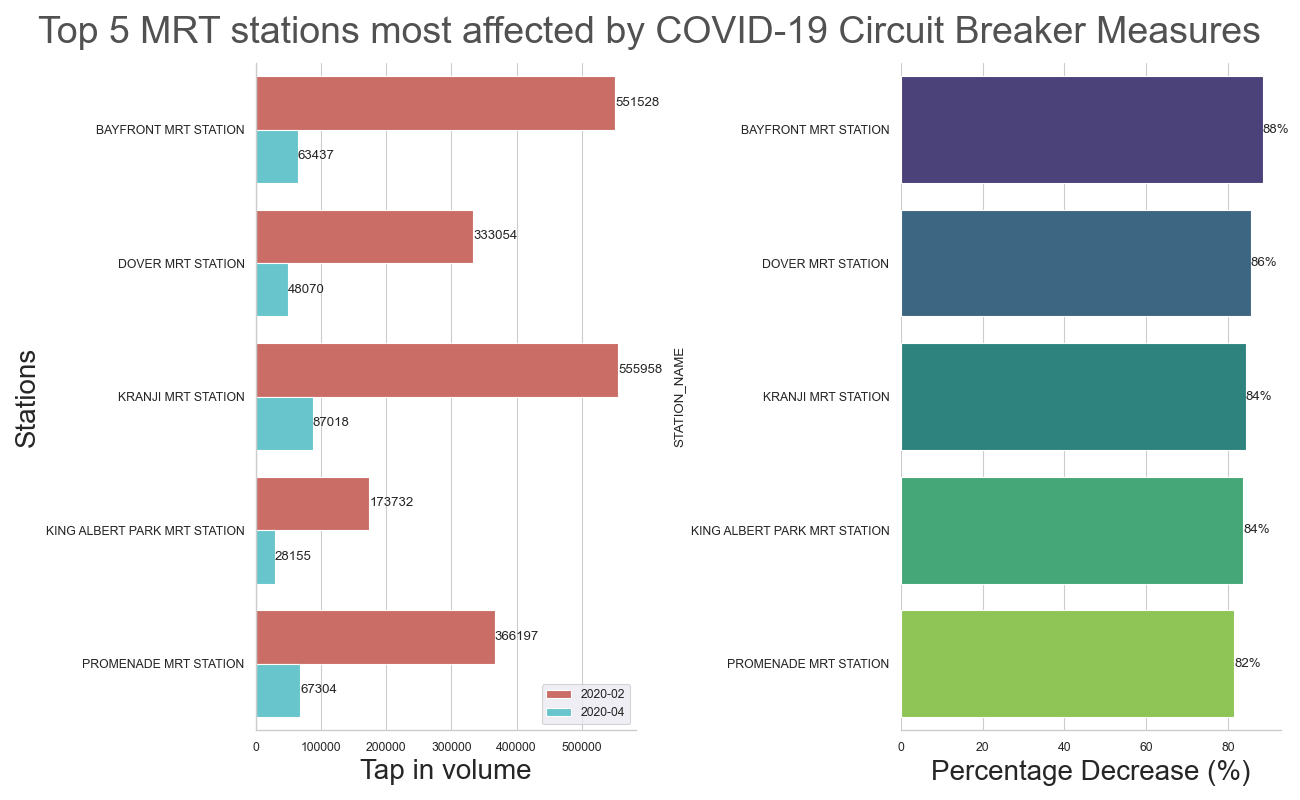

In [170]:
_month02 = finaldf[(finaldf.YEAR_MONTH == '2020-02') & (finaldf.STATION_NAME.str.contains('MRT')) ].groupby('STATION_NAME')['TOTAL_TAP_IN_VOLUME'].sum()
_month04 = finaldf[(finaldf.YEAR_MONTH == '2020-04') & (finaldf.STATION_NAME.str.contains('MRT')) ].groupby('STATION_NAME')['TOTAL_TAP_IN_VOLUME'].sum()
pctDecrease = ((_month02 - _month04)/_month02)*100 
pctDecrease.sort_values(ascending = False , inplace = True)
top5 = pctDecrease.head(5)

sns.set(context = 'paper')
covid = plt.figure( figsize = (13,8))

with sns.axes_style("whitegrid"):
    baraxis   = covid.add_subplot(121)
    bp1 = sns.barplot(hue = 'YEAR_MONTH' , x = 'TOTAL_TAP_IN_VOLUME' , ax = baraxis  , estimator = np.sum ,  orient =  "h" , y = 'STATION_NAME' ,
            data = finaldf[(finaldf["STATION_NAME"].map(lambda x: True in [x in s for s in top5.index]) ) & (finaldf.YEAR_MONTH.map(lambda x: True in [x in s for s in['2020-02'  , '2020-04' ] ]))] ,
                ci = None , order =top5.index,palette="hls" )
sns.despine(fig=None, ax=None, top=True,right = True, offset=None, trim = False)

with sns.axes_style('whitegrid'):
    percentageax = covid.add_subplot(122 , sharey = baraxis)
    sns.despine(left = True , ax = percentageax)
    bp2 = sns.barplot(orient = 'h' , x = top5.round(1) , y = top5.index  , ax = percentageax, order =top5.index, palette = 'viridis')
    
    
covid.suptitle("Top 5 MRT stations most affected by COVID-19 Circuit Breaker Measures" ,alpha=0.8 , fontsize = 27, )
baraxis.set_ylabel("Stations" ,  fontsize = 20 )
baraxis.set_xlabel("Tap in volume", fontsize = 20)
baraxis.legend(loc='best')
percentageax.set_xlabel("Percentage decrease (%)", fontsize = 20)

# Labels.
for container in bp1.containers:
    bp1.bar_label(container)

bp2.bar_label(bp2.containers[0],fmt='%.f%%')

plt.tight_layout()
plt.show()
